In [298]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import math
import plotly.graph_objs as go
import plotly.offline as py

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [18, 8]

In the 1st step we are going to load the three datasets:

-Movies data

-User data

-Ratings

And do some analysis of the raw data

In [299]:
# Information about the MovieLens dataset
info = pd.read_csv('ml-100k/u.info', sep=" ", header=None)
info.columns=['Counts', 'Type']
info

,Counts,Type
0,943,users
1,1682,items
2,100000,ratings


In [300]:
# Load the Movies data 
movies = pd.read_csv('ml-100k/u.item', names=['movie id', 'movie title' ,'release date','video release date', 'IMDb URL', 'unknown', 'Action', 
                'Adventure', 'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 
                'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'], sep="|", encoding='latin-1', header=None)

# drop video release date and URL 
movies.drop(['video release date'], axis=1, inplace=True)
movies.drop(['IMDb URL'], axis=1, inplace=True)

movies.head()

,movie id,movie title,release date,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [301]:
# Types of genres
genre = pd.read_csv('ml-100k/u.genre', sep="|", encoding='latin-1', header=None)
genre.drop(genre.columns[1], axis=1, inplace=True)
genre.columns = ['Genres']
genre_list = list(genre['Genres'])
genre_list


['unknown',
 'Action',
 'Adventure',
 'Animation',
 "Children's",
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western']

In [302]:
#Load the User data
user = pd.read_csv('ml-100k/u.user', names=['user id', 'age', 'gender', 'occupation', 'zip code'], sep="|", encoding='latin-1', header=None)
user.drop(['zip code'], axis=1, inplace=True)
# Convert 'M' and 'F' to 0 and 1
user['gender'] = np.where(np.matrix(user['gender']) =='M',0,1)[0]
user.head()

,user id,age,gender,occupation
0,1,24,0,technician
1,2,53,1,other
2,3,23,0,writer
3,4,24,0,technician
4,5,33,1,other


In [303]:
#Types of occupations
occupation = pd.read_csv('ml-100k/u.occupation', sep="|", encoding='latin-1', header=None)
occupation.columns = ['Occupations']
occupation_list = list(occupation['Occupations'])
occupation_list

['administrator',
 'artist',
 'doctor',
 'educator',
 'engineer',
 'entertainment',
 'executive',
 'healthcare',
 'homemaker',
 'lawyer',
 'librarian',
 'marketing',
 'none',
 'other',
 'programmer',
 'retired',
 'salesman',
 'scientist',
 'student',
 'technician',
 'writer']

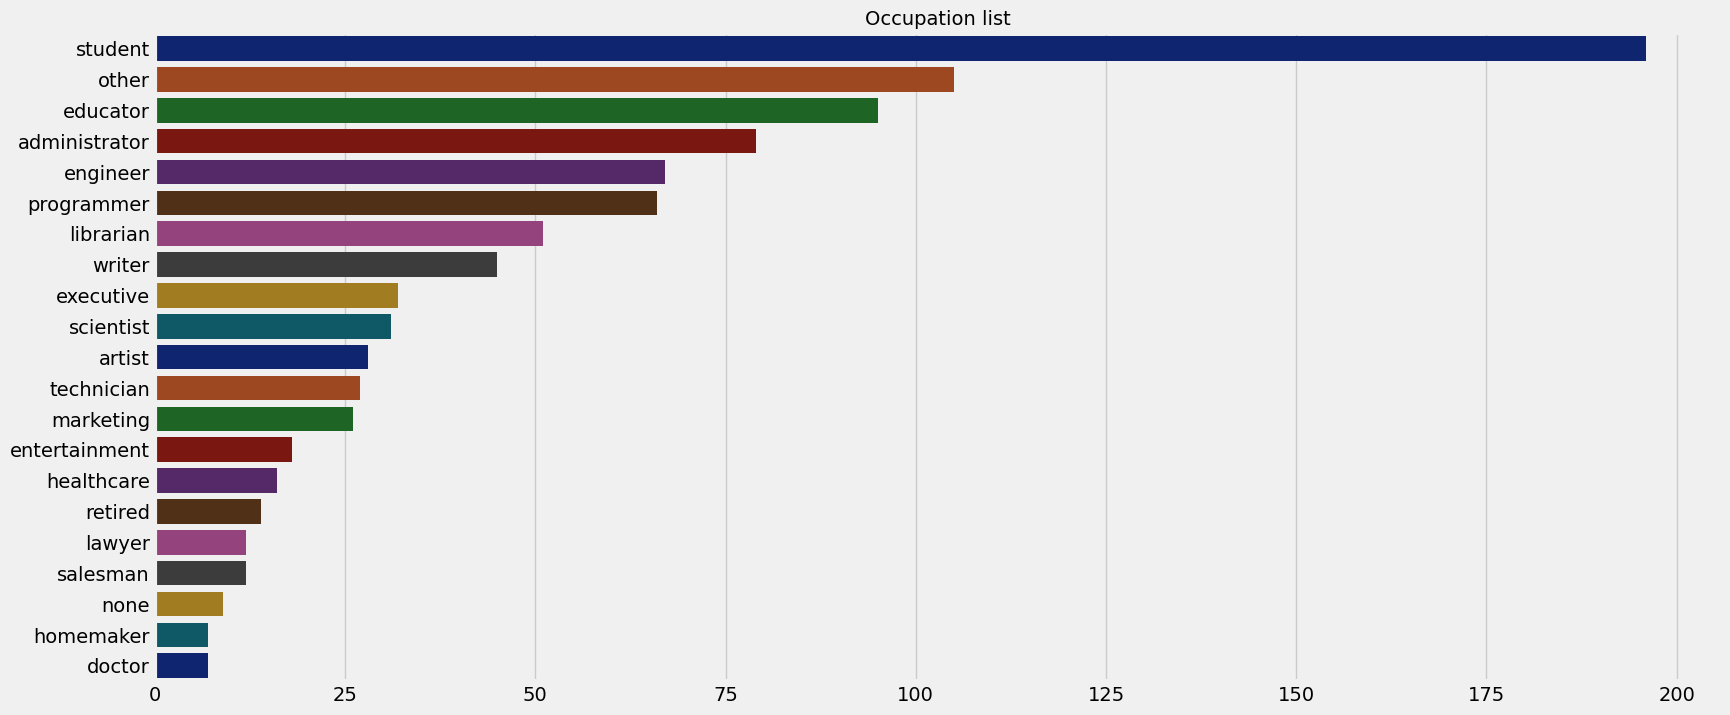

In [304]:
occupation_counts = user['occupation'].value_counts().sort_values(ascending=False)

sns.barplot(x=occupation_counts.values,
            y=occupation_counts.index,
            palette='dark').set_title(
                'Occupation list', fontsize=14)

plt.show()

#https://www.kaggle.com/code/indralin/movielens-project-1-2-collaborative-filtering

In [305]:
gender_counts = user['gender'].value_counts()

colors1 = ['dodgerblue', 'pink']

pie = go.Pie(labels=gender_counts.index,
             values=gender_counts.values,
             marker=dict(colors=colors1),
             hole=0.5)

layout = go.Layout(title='Male & Female users', font=dict(size=18), legend=dict(orientation='h'))

fig = go.Figure(data=[pie], layout=layout)
py.iplot(fig)

#https://www.kaggle.com/code/indralin/movielens-project-1-2-collaborative-filtering

In [306]:
# bucketize user age

ages_bins = np.array([1,17,24,34,44,49,56])
user['age_bucketized'] = pd.cut(user['age'], ages_bins)
np.histogram(user['age'], ages_bins)


(array([ 22, 179, 326, 188,  84,  98], dtype=int64),
 array([ 1, 17, 24, 34, 44, 49, 56]))

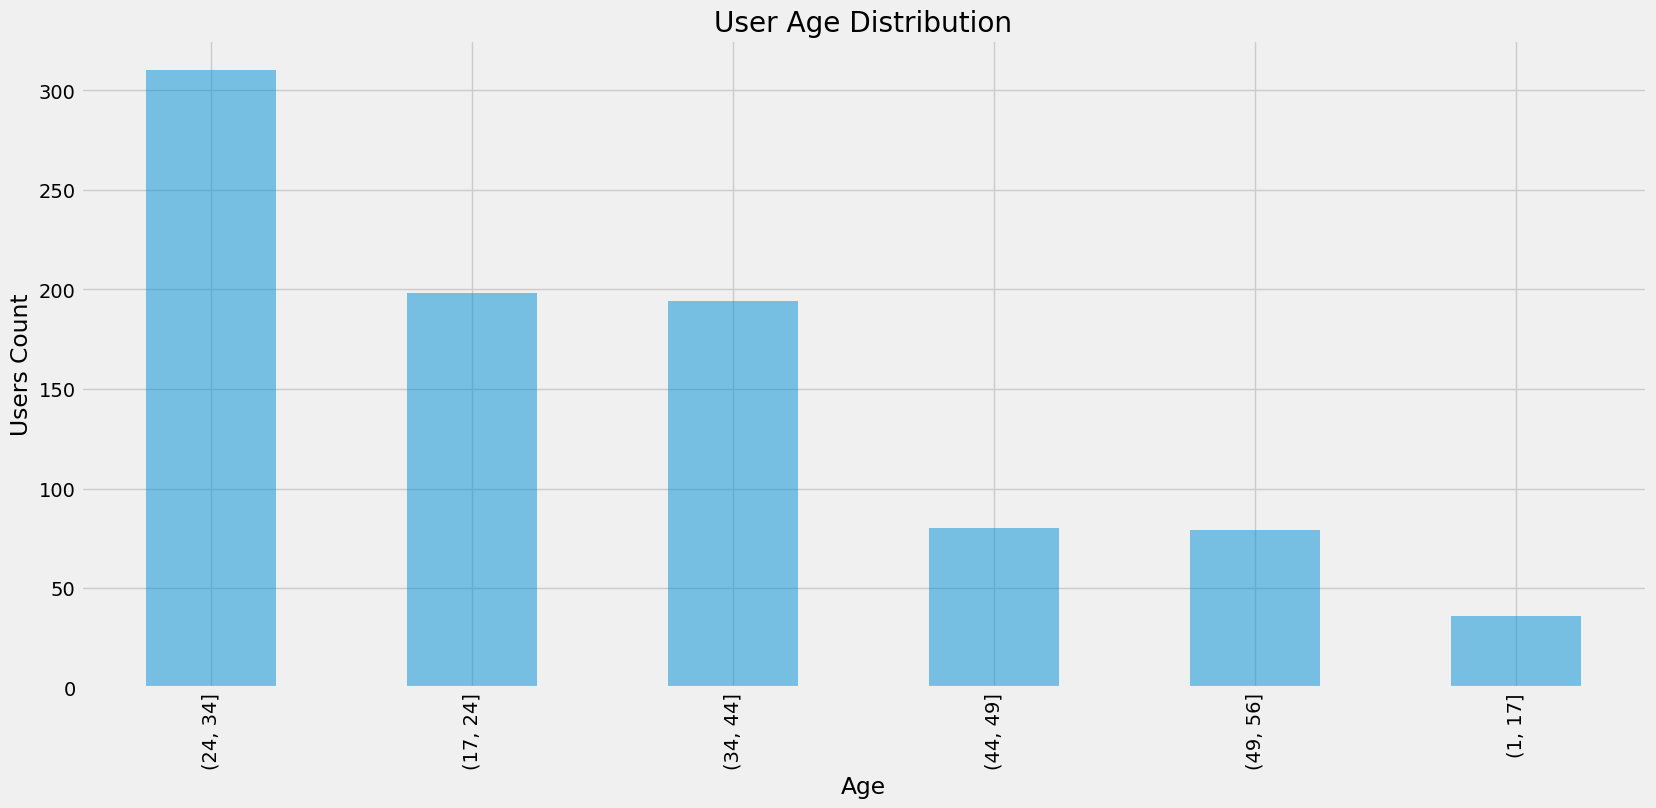

In [307]:
age_counts = user['age_bucketized'].value_counts().plot(kind='bar', alpha=0.5) #https://www.kaggle.com/code/tusharkale/movielens-case-study
plt.xlabel('Age')
plt.title('User Age Distribution')
plt.ylabel('Users Count')
plt.show()

We can see that most of the users are between 25 and 34.

In [308]:
ratings = pd.read_csv('ml-100k/u.data', names=['user id', 'movie id', 'rating', 'timestamp'], sep="\t", header=None)
ratings.head()

,user id,movie id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [309]:
print('Ratings shape:', ratings.shape)
print('Users shape:', user.shape)
print('Movies shape:', movies.shape)

Ratings shape: (100000, 4)
Users shape: (943, 5)
Movies shape: (1682, 22)


In the 2nd step we are merging the movies data and user data with the ratings.

Also some further data analysis is done.

In [310]:
df_merged = ratings.merge(movies, on='movie id', how='left').merge(user, on='user id', how='left')

print('df_merged shape:', df_merged.shape)

df_merged.head()

#https://www.kaggle.com/code/indralin/movielens-project-1-2-collaborative-filtering

df_merged shape: (100000, 29)


,user id,movie id,rating,timestamp,movie title,release date,unknown,Action,Adventure,Animation,...,Mystery,Romance,Sci-Fi,Thriller,War,Western,age,gender,occupation,age_bucketized
0,196,242,3,881250949,Kolya (1996),24-Jan-1997,0,0,0,0,...,0,0,0,0,0,0,49,0,writer,"(44, 49]"
1,186,302,3,891717742,L.A. Confidential (1997),01-Jan-1997,0,0,0,0,...,1,0,0,1,0,0,39,1,executive,"(34, 44]"
2,22,377,1,878887116,Heavyweights (1994),01-Jan-1994,0,0,0,0,...,0,0,0,0,0,0,25,0,writer,"(24, 34]"
3,244,51,2,880606923,Legends of the Fall (1994),01-Jan-1994,0,0,0,0,...,0,1,0,0,1,1,28,0,technician,"(24, 34]"
4,166,346,1,886397596,Jackie Brown (1997),01-Jan-1997,0,0,0,0,...,0,0,0,0,0,0,47,0,educator,"(44, 49]"


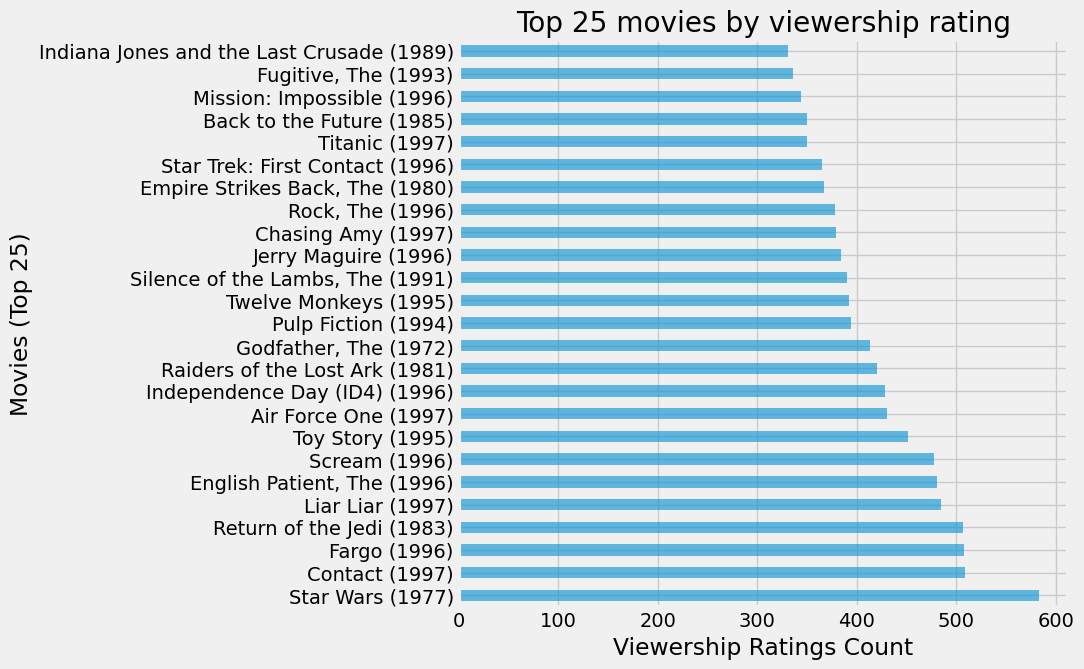

In [311]:
# Top 25 movies by rating

dfTop25 = df_merged.groupby('movie title').size().sort_values(ascending=False)[:25]
dfTop25

dfTop25.plot(kind='barh',alpha=0.6,figsize=(7,7))
plt.xlabel("Viewership Ratings Count")
plt.ylabel("Movies (Top 25)")
plt.title("Top 25 movies by viewership rating")
plt.show()

#https://www.kaggle.com/code/tusharkale/movielens-case-study

In [312]:
# Top 7 movies watched by user aged 30

df_merged[df_merged['age'] == 30]['movie title'].value_counts()[:7]

Star Wars (1977)                   24
Fargo (1996)                       23
Contact (1997)                     22
Toy Story (1995)                   20
Star Trek: First Contact (1996)    20
English Patient, The (1996)        20
Liar Liar (1997)                   20
Name: movie title, dtype: int64

In [313]:
# Movies watched and rated by user 269

userId = 269
userRatingById = df_merged[df_merged['user id'] == userId]
userRatingById

,user id,movie id,rating,timestamp,movie title,release date,unknown,Action,Adventure,Animation,...,Mystery,Romance,Sci-Fi,Thriller,War,Western,age,gender,occupation,age_bucketized
153,269,504,4,891449922,Bonnie and Clyde (1967),01-Jan-1967,0,0,0,0,...,0,0,0,0,0,0,31,1,librarian,"(24, 34]"
230,269,127,4,891446165,"Godfather, The (1972)",01-Jan-1972,0,1,0,0,...,0,0,0,0,0,0,31,1,librarian,"(24, 34]"
284,269,367,3,891450023,Clueless (1995),01-Jan-1995,0,0,0,0,...,0,0,0,0,0,0,31,1,librarian,"(24, 34]"
397,269,522,5,891447773,Down by Law (1986),01-Jan-1986,0,0,0,0,...,0,0,0,0,0,0,31,1,librarian,"(24, 34]"
408,269,845,1,891456255,That Thing You Do! (1996),28-Sep-1996,0,0,0,0,...,0,0,0,0,0,0,31,1,librarian,"(24, 34]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96939,269,1267,1,891448643,Clockers (1995),01-Jan-1995,0,0,0,0,...,0,0,0,0,0,0,31,1,librarian,"(24, 34]"
98132,269,708,4,891448323,"Sex, Lies, and Videotape (1989)",01-Jan-1989,0,0,0,0,...,0,0,0,0,0,0,31,1,librarian,"(24, 34]"
98684,269,823,3,891446514,Mulholland Falls (1996),26-Apr-1996,0,0,0,0,...,0,0,0,1,0,0,31,1,librarian,"(24, 34]"
99321,269,124,5,891446165,Lone Star (1996),21-Jun-1996,0,0,0,0,...,1,0,0,0,0,0,31,1,librarian,"(24, 34]"


Further data analysis

In [314]:
df_merged.groupby(['movie id', 'movie title']).agg({'rating': 'mean', 'user id': 'count'}).rename(columns={'user id': 'n_reviews'}).sort_values('rating', ascending=False)

#https://antonai.blog/how-to-create-a-recommendation-system-from-scratch-using-keras/

,,rating,n_reviews
movie id,movie title,,
814,"Great Day in Harlem, A (1994)",5.0,1
1599,Someone Else's America (1995),5.0,1
1201,Marlene Dietrich: Shadow and Light (1996),5.0,1
1122,They Made Me a Criminal (1939),5.0,1
1653,Entertaining Angels: The Dorothy Day Story (1996),5.0,1
...,...,...,...
1568,Vermont Is For Lovers (1992),1.0,1
1567,Careful (1992),1.0,1
1566,"Man from Down Under, The (1943)",1.0,1


In [315]:
#filter movies with less than 10 reviews

df_top_review = df_merged.groupby(['movie id', 'movie title']).agg({'rating': 'mean', 'user id': 'count'}).rename(columns={'user id': 'n_reviews'})
df_top_review = df_top_review[df_top_review.n_reviews > 10]
df_top_review.sort_values("rating", ascending=False)[:10]

#https://antonai.blog/how-to-create-a-recommendation-system-from-scratch-using-keras/

,,rating,n_reviews
movie id,movie title,,
408,"Close Shave, A (1995)",4.491071,112
318,Schindler's List (1993),4.466443,298
169,"Wrong Trousers, The (1993)",4.466102,118
483,Casablanca (1942),4.456790,243
114,Wallace & Gromit: The Best of Aardman Animation (1996),4.447761,67
64,"Shawshank Redemption, The (1994)",4.445230,283
603,Rear Window (1954),4.387560,209
12,"Usual Suspects, The (1995)",4.385768,267
50,Star Wars (1977),4.358491,583


In [316]:
# most reviewd movies

df_top_review.sort_values('n_reviews', ascending=False)[:10]

#https://antonai.blog/how-to-create-a-recommendation-system-from-scratch-using-keras/

,,rating,n_reviews
movie id,movie title,,
50,Star Wars (1977),4.358491,583
258,Contact (1997),3.803536,509
100,Fargo (1996),4.155512,508
181,Return of the Jedi (1983),4.007890,507
294,Liar Liar (1997),3.156701,485
286,"English Patient, The (1996)",3.656965,481
288,Scream (1996),3.441423,478
1,Toy Story (1995),3.878319,452
300,Air Force One (1997),3.631090,431


Data Pre-processing 

Starting with the encoding of the movies ID, users ID and other users properties.

In [317]:
#n_user_ids = df_merged['user id'].unique()
user_ids = df_merged['user id'].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}

user_age = [0]
for ints in df_merged['age'].unique().tolist():

    if math.isnan(ints):
        user_age.append(0)
    else:
        user_age.append(int(ints))
        
age2age_encoded = {x: i for i, x in enumerate(user_age)}
age_encoded2age = {i: x for i, x in enumerate(user_age)}


user_gender = df_merged['gender'].unique().tolist()
gender2gender_encoded = {x: i for i, x in enumerate(user_gender)}
gender_encoded2gender = {i: x for i, x in enumerate(user_gender)}

movie_ids = df_merged['movie id'].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}

df_merged['user'] = df_merged['user id'].map(user2user_encoded)
df_merged['age'] = df_merged['age'].map(age_encoded2age)
df_merged['gender'] = df_merged['gender'].map(age_encoded2age)
df_merged['movie'] = df_merged['movie id'].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_age = len(age_encoded2age),
num_gender = len(gender_encoded2gender)
num_movies = len(movie_encoded2movie)


df_merged['rating'] = df_merged['rating'].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df_merged['rating'])
max_rating = max(df_merged['rating'])

print(
    "Number of Movies: {}, Number of users: {}, Number of ages: {}, Number of genders: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, num_age, num_gender, min_rating, max_rating
    )
)

#https://keras.io/examples/structured_data/collaborative_filtering_movielens/



Number of Movies: 943, Number of users: 1682, Number of ages: (62,), Number of genders: 2, Min rating: 1.0, Max rating: 5.0


Prepare the data for training and validation.

In [318]:
# Random split.

df = df_merged.sample(frac=1, random_state=42)
x = df[['user', 'movie']].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 80% of the data and validating on 10%.
train_indices = int(0.8 * df.shape[0])
x_train_rand, x_val_rand, y_train_rand, y_val_rand = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

#https://keras.io/examples/structured_data/collaborative_filtering_movielens/


Create the models

In [319]:
EMBEDDING_SIZE = 50

class RecommenderNet_1(tf.keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet_1, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size

        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)

        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)

# https://keras.io/examples/structured_data/collaborative_filtering_movielens/

In [320]:
model_1 = RecommenderNet_1(num_users, num_movies, EMBEDDING_SIZE)
model_1.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
)

Train the models

Epoch 1/5
1250/1250 [==============================] - 3s 2ms/step - loss: 0.6535 - val_loss: 0.6369
Epoch 2/5
1250/1250 [==============================] - 2s 2ms/step - loss: 0.6289 - val_loss: 0.6292
Epoch 3/5
1250/1250 [==============================] - 2s 2ms/step - loss: 0.6204 - val_loss: 0.6219
Epoch 4/5
1250/1250 [==============================] - 2s 2ms/step - loss: 0.6178 - val_loss: 0.6184
Epoch 5/5
1250/1250 [==============================] - 2s 2ms/step - loss: 0.6171 - val_loss: 0.6188


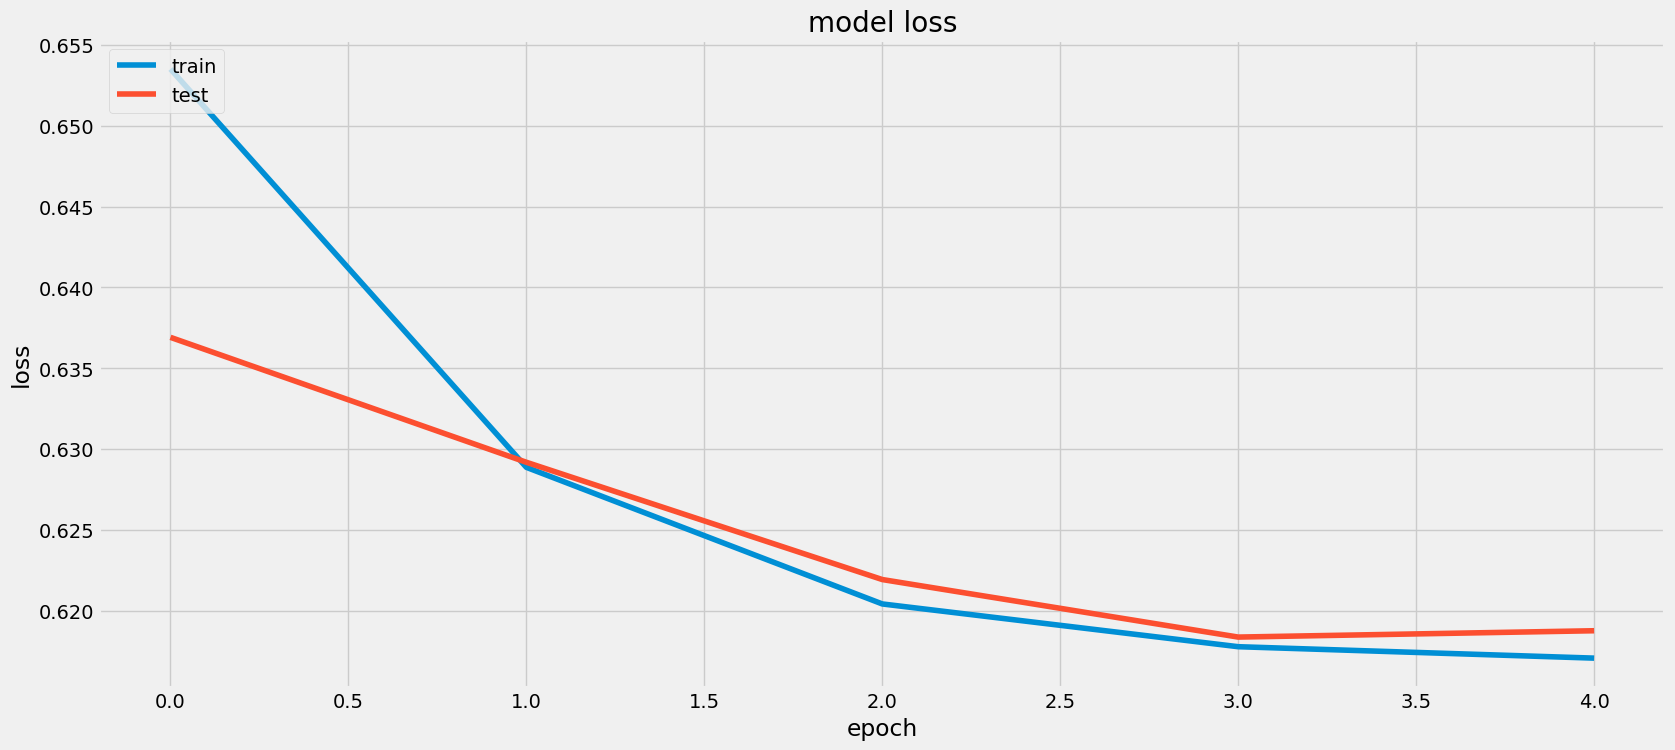

In [321]:
history_1 = model_1.fit(
    x=x_train_rand,
    y=y_train_rand,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(x_val_rand, y_val_rand),
)

plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [322]:
validation_acc = model_1.evaluate(x_train_rand, y_train_rand)
print('validation accuracy:', validation_acc)

2500/2500 [==============================] - 4s 1ms/step - loss: 0.6150
validation accuracy: 0.6150109171867371


In [323]:
model_1.summary()

Model: "recommender_net_1_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_152 (Embedding)   multiple                  47150     
                                                                 
 embedding_153 (Embedding)   multiple                  943       
                                                                 
 embedding_154 (Embedding)   multiple                  84100     
                                                                 
 embedding_155 (Embedding)   multiple                  1682      
                                                                 
Total params: 133,875
Trainable params: 133,875
Non-trainable params: 0
_________________________________________________________________
